# Global sensitivity Analysis for PULPO

In this notebook we show the workflow for the global sensitivity analysis (GSA) in PULPO.

In [44]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('../')
from pulpo import pulpo
import scipy.sparse as sparse
from time import time
import stats_arrays

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pyomo.environ as pyo
from pyomo.repn.plugins.baron_writer import *
import pandas as pd
from pathlib import Path
from IPython.display import display
def extract_results(instance, project, database, choices, constraints, demand, process_map, process_map_metadata, itervention_map, itervention_map_metadata, directory, name):
    """
    Args:
        instance: The Pyomo model instance.
        project (str): Name of the project.
        database (str): Name of the database.
        choices (dict): Choices for the model.
        constraints (dict): Constraints applied during optimization.
        demand (dict): Demand data used in optimization.
        process_map (dict): Mapping of process IDs to descriptions.
        process_map_metadata (dict): Metadata to the process_map
        itervention_map (dict): Mapping of intervention IDs to descriptions.
        itervention_map_metadata (dict): Metadata of the itervention_map.
        directory (str): Directory to save the results file.
        name (str): Name of the results file.
    """
    # Recover dictionary values
    list_of_vars = []
    for v in instance.component_objects(ctype=pyo.Var, active=True, descend_into=True):
        for e in v._data:
            v._data[e] = value(v[e])
        list_of_vars.append(v)

    result_data = {}
    inverse_process_map = dict((v, k) for k, v in process_map.items())
    inverse_itervention_map = dict((v, k) for k, v in itervention_map.items())
    # Raw results
    for v in list_of_vars:
        try:
            if str(v) == 'inv_flows' or str(v) == 'inv_vector':
                data = [(k, inverse_itervention_map[k], itervention_map_metadata[k], v) for k, v in v._data.items()]
            else:
                data = [(k, inverse_process_map[k], process_map_metadata[k], v) for k, v in v._data.items()]
            df = pd.DataFrame(data, columns=['ID', 'Process name', "Process metadata", 'Value'])
        except:
            data = [(k, v) for k, v in v._data.items()]
            df = pd.DataFrame(data, columns=['Key', 'Value'])
        df.sort_values(by=['Value'], inplace=True, ascending=False)
        result_data[v.name] = df

    # Normalize database to a list if it is a string
    if isinstance(database, str):
        database = [database]

    # Store the metadata
    result_data["project and db"] = pd.DataFrame([f"{project}__{db}" for db in database])

    choices_data = {}
    for choice in choices:
        i = 0
        temp_dict = []
        for alt in choices[choice]:
            temp_dict.append((alt, i, instance.scaling_vector[process_map[alt.key]]))
            i+=1
        choices_data[(choice, 'Process')] = {'Process ' + str(i): process_map_metadata[process_map[alt.key]] for alt, i, val in temp_dict}
        choices_data[(choice, 'Capacity')] = {'Process ' + str(i): choices[choice][alt] for alt, i, val in temp_dict}
        choices_data[(choice, 'Value')] = {'Process ' + str(i): x for alt, i, x in temp_dict}
    result_data["choices"] = pd.DataFrame(choices_data)

    result_data["demand"] = pd.DataFrame({"demand":{
        process_map_metadata[process_map[key]] if key in process_map else key: demand[key]
        for key in demand
    }})
    result_data["constraints"] = pd.DataFrame({"Demand": {process_map_metadata[process_map[key]]: constraints[key] for key in constraints}})

    return result_data

def save_results(result_data, file_name):
    with pd.ExcelWriter(f"{directory}/results/{file_name}.xlsx") as writer:
        for sheet_name, dataframe in result_data.items():
            dataframe.to_excel(writer, sheet_name=sheet_name)

## 1. Defining the case

The case for which the sensitivity analysis will be performed for is on a solution of the LP:

$$
    \begin{align}
        & \underset{s, slack}{\text{min}}  && z_h \\
        & \text{s.t.}   && \sum_{j}(a_{i,j}\cdot s_j) = f_i && \forall i \\
        &               && s_j^{low} \leq s_j \leq s_j^{high} && \forall j \\
        &               && z_h = \sum_e \sum_j (q_{h,e}\cdot b_{e,j} \cdot s_j) && \forall h \\
    \end{align}
$$


### 1.1. Rice husk problem


#### 1.1.1. Loading the the data

If the rise husk database has not been installed yet

In [ ]:
# pulpo.install_rice_husk_db()

Set the parameters for the rise husk example to instancialize PULPO

In [ ]:
project = "rice_husk_example" 
database = "rice_husk_example_db"
method = "('my project', 'climate change')"
notebook_dir = os.path.dirname(os.getcwd())
directory = os.path.join(notebook_dir, 'develop_tests/data')

Create a **PulpoOptimizer** instance. This class is used to interact with the LCI database and solve the optimization problem. It is specified by the project, database, method and directory.

In [ ]:
pulpo_worker = pulpo.PulpoOptimizer(project, database, method, directory)

Import LCI data. After initializing the PulpoOptimizer instance, the LCI data is imported from the database.

In [ ]:
pulpo_worker.get_lci_data()

#### 1.1.2. Defining the optimizaiton problem

Specify the **functional unit**. In this case, the functional unit is 1 Mt of processed rice. PULPO implements a search function (```retrieve_processes```) to find the processes that match the specified reference products (alternatively: keys, process name, region).

In [ ]:
rice_factory = pulpo_worker.retrieve_processes(reference_products='Processed rice (in Mt)')

demand = {rice_factory[0]: 1}

Specify the **choices**. Here, the choices are regional 🌐 choices for rise husk collections, and technological ⛏ choices for boiler type selection.

The auxiliar choices are needed to resolve the issue that rice, when not used in the boiler must be burned instead. 

(*At this point, just accept. If you are curious about how this multi-functionality is technically adressed, refer to the paper, or reach out.*)

In [ ]:
## Rise husk collection
rice_husk_processes = ["Rice husk collection 1",
              "Rice husk collection 2",
              "Rice husk collection 3",
              "Rice husk collection 4",
              "Rice husk collection 5",]
rice_husk_collections = pulpo_worker.retrieve_processes(processes=rice_husk_processes)

In [ ]:
## Boilers
boiler_processes = ["Natural gas boiler",
                     "Wood pellet boiler",
                     "Rice husk boiler"]
boilers = pulpo_worker.retrieve_processes(processes=boiler_processes)

In [ ]:
## Auxiliar (Ignore for now!)
auxiliar_processes = ["Rice husk market",
                       "Burning of rice husk"]
auxiliar = pulpo_worker.retrieve_processes(processes=auxiliar_processes)

In [ ]:
## Combine to create the choices dictionary
## For each kind of choice, assign a 'label' (e.g. 'boilers')
## To each possible choice, assign a process capacity. In the 'unconstrained' case, set this value very high (e.g. 1e10, but depends on the scale of the functional unit)
choices = {'Rice Husk (Mt)': {rice_husk_collections[0]: 0.03,
                              rice_husk_collections[1]: 0.03,
                              rice_husk_collections[2]: 0.03,
                              rice_husk_collections[3]: 0.03,
                              rice_husk_collections[4]: 0.03},
           'Thermal Energy (TWh)': {boilers[0]: 1e10,
                                    boilers[1]: 1e10,
                                    boilers[2]: 1e10},
           'Auxiliar': {auxiliar[0]: 1e10,
                        auxiliar[1]: 1e10}}

#### 1.1.3. Instantiat and solve the optimization model

In [ ]:
pulpo_worker.instantiate(choices=choices, demand=demand)

In [ ]:
results = pulpo_worker.solve()

#### 1.1.4. Save and summarize the results

In [ ]:
result_data = extract_results(pulpo_worker.instance, pulpo_worker.project, pulpo_worker.database, choices, {}, demand,
                            pulpo_worker.lci_data['process_map'], pulpo_worker.lci_data['process_map_metadata'],
                            pulpo_worker.lci_data['intervention_map'], pulpo_worker.lci_data['intervention_map_metadata'],
                            pulpo_worker.directory, "")
result_data
# pulpo_worker.summarize_results(choices=choices, demand=demand, zeroes=True)

In [ ]:
save_results(result_data, "new_test_extract_data")

### 1.2. Defining the electricity showcase problem

#### 1.2.1. Import the data

In [3]:
# Your brightway2 project, database and targeted impact category
project = "pulpo"
database = "cutoff38"
methods = {"('IPCC 2013', 'climate change', 'GWP 100a')": 0,
           "('ReCiPe Endpoint (E,A)', 'resources', 'total')": 1,
           "('ReCiPe Endpoint (E,A)', 'human health', 'total')": 0,
           "('ReCiPe Endpoint (E,A)', 'ecosystem quality', 'total')": 0,
           "('ReCiPe Midpoint (E) V1.13', 'ionising radiation', 'IRP_HE')": 0}

# Substitute with your working directory of choice
notebook_dir = os.path.dirname(os.getcwd())
directory = os.path.join(notebook_dir, 'data')

In [4]:
# Create a PULPO object
pulpo_worker = pulpo.PulpoOptimizer(project, database, methods, directory)

In [5]:
# Retrieve LCI data
pulpo_worker.get_lci_data()

#### 1.2.2. Define the optimization problem

In [6]:
# Retrieve the electricity market
activities = ["market for electricity, high voltage"]
reference_products = ["electricity, high voltage"]
locations = ["DE"]
electricity_market = pulpo_worker.retrieve_activities(activities=activities,
                                                      reference_products=reference_products,
                                                      locations=locations)

In [7]:
# Specify the functional unit as demand dictionary
demand = {electricity_market[0]: 1.28819e+11}

In [8]:
# Retrieve the choices
activities = ["electricity production, lignite", 
             "electricity production, hard coal",
             "electricity production, nuclear, pressure water reactor",
             "electricity production, wind, 1-3MW turbine, onshore"]
reference_products = ["electricity, high voltage"]
locations = ["DE"]

electricity_activities = pulpo_worker.retrieve_activities(activities=activities,
                                                          reference_products=reference_products,
                                                          locations=locations)

In [9]:
# Specify the choices dictionary
choices  = {'electricity': {electricity_activities[0]: 1e16,
                            electricity_activities[1]: 1e16,
                            electricity_activities[2]: 1e16,
                            electricity_activities[3]: 1e16}}

#### 1.2.3. Initialize and solve the optimization problem

In [10]:
# Instantiate and solve the problem (here with HiGHS)
instance = pulpo_worker.instantiate(choices=choices, demand=demand)

Creating Instance
Instance created


In [11]:
# import pyomo.environ as pyon
# import os
# os.environ['NEOS_EMAIL'] = 'b.j.p.m.haussling.lowgren@cml.leidenuniv.nl'
# solver_manager = pyon.SolverManagerFactory('neos')

In [12]:
# from contextlib import redirect_stdout
# with open(r'pyomo_optimization_model_electricity_showcase.txt', 'w') as f:
#     with redirect_stdout(f):
#         pulpo_worker.instance.pprint()

In [13]:
# results = solver_manager.solve(pulpo_worker.instance, opt='cplex', tee=True)

In [14]:
pulpo_worker.solve()

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Cols:       39128 lower bounds exceeding       -1e+20 are treated as -Infinity
Cols:       39128 upper bounds exceeding        1e+20 are treated as +Infinity
Rows:       19561 lower bounds exceeding       -1e+20 are treated as -Infinity
Rows:       19562 upper bounds exceeding        1e+20 are treated as +Infinity


#### 1.2.4. Summarize and save the results

In [15]:
result_data = extract_results(pulpo_worker.instance, pulpo_worker.project, pulpo_worker.database, choices, {}, demand,
                            pulpo_worker.lci_data['process_map'], pulpo_worker.lci_data['process_map_metadata'],
                            pulpo_worker.lci_data['intervention_map'], pulpo_worker.lci_data['intervention_map_metadata'],
                            pulpo_worker.directory, "")
result_data

{'impacts':                                                Key         Value
 0  ('ReCiPe Endpoint (E,A)', 'resources', 'total')  6.763921e+08,
 'scaling_vector':           ID                                  Process name  \
 14779  14779  (cutoff38, 0cbb759cc5686df90185c3fbc7b8262b)   
 637      637  (cutoff38, 2040efe62886e6f108756a2b60d663a1)   
 7239    7239  (cutoff38, 962727b9a36bcaa186f222b29b57f6a3)   
 6498    6498  (cutoff38, 0058af82cdce10e512dc11f68a00a8eb)   
 15234  15234  (cutoff38, e4b81a6357b79091e76dc2836ef1fc52)   
 ...      ...                                           ...   
 2028    2028  (cutoff38, 8e8cdd680e8d61271f4fa838a24bed1a)   
 13440  13440  (cutoff38, 0bb079bf4e6142ad612b2b08e043f4ba)   
 5551    5551  (cutoff38, 9b0bb421368f11d8ad6fd72066eca3d0)   
 14649  14649  (cutoff38, 18955e2d43eeb55c9ae99705a5170cca)   
 3478    3478  (cutoff38, 20ad13627c3972f28128f77858330dee)   
 
                                         Process metadata         Value  
 14779

## 2. Preparing the data for the sensitivity analysis

**Reformulating the problem for the sensitivity analysis**

We only consider uncertainty in the $B$ and $Q$ parameter matrizes. The scaling vector is given by the optimal solution.

We will look at the environmental impact objective:

$$
    e(Q, B) =  Q \cdot B \cdot s
$$

### 2.0. Preparing the sampling of the parameter space

In [17]:
# Loop place holer, will loop over all the following code
# method_index = 1
# for i_method, ((mat_method, mat_characterization_matrix), (param_mat, param_characterization_params)) in enumerate(zip(pulpo_worker.lci_data["matrices"].items(), pulpo_worker.lci_data["characterization_params"].items())):
#     if i_method == method_index:
#         method = mat_method
#         characterization_matrix = mat_characterization_matrix
#         characterization_params = param_characterization_params
#         print(method)
method = result_data['impacts']['Key'][0]
characterization_matrix = pulpo_worker.lci_data["matrices"][method]
characterization_params = pulpo_worker.lci_data["characterization_params"][method]
method

"('ReCiPe Endpoint (E,A)', 'resources', 'total')"

In [18]:
# put the scaling vector returned from the optimization into the same order as the process map
scaling_vector_series = result_data["scaling_vector"]["Value"].reindex(pulpo_worker.lci_data['process_map'].values())


### 2.1. Compute the LCI and LCIA results per flow

In [19]:
# LCI calculatiom
count = len(pulpo_worker.lci_data["process_map"])
inventory = pulpo_worker.lci_data['intervention_matrix'] * \
sparse.spdiags([scaling_vector_series.values], [0], count, count)

In [20]:
# LCIA calculation
characterized_inventory = \
characterization_matrix * inventory
lca_score = characterized_inventory.sum()
print('The total impact is: {:e}'.format(lca_score))

The total impact is: 6.763921e+08


### 2.2. Filtering out the Biosphereflows $B_{i,j}$ that have a neglectable impact

In [30]:
#ATTN: Add a simple optimization loop to find the cutoff which results in an absolute change of around 1%
cutoff = 0.0005

In [31]:
# Filters the biosphere flows
start = time()
print('Characterized inventory:', characterized_inventory.shape, characterized_inventory.nnz)
finv = characterized_inventory.multiply(abs(inventory) > abs(lca_score*cutoff))
print('Filtered characterized inventory:', finv.shape, finv.nnz)
characterized_inventory_indices = list(zip(*finv.nonzero()))
explained_fraction = finv.sum() / lca_score
print('Explained fraction of LCA score:', explained_fraction)
print('BIOSPHERE {} filtering resulted in {} of {} exchanges ({}% of total impact) and took {} seconds.'.format(
    characterized_inventory.shape,
    finv.nnz,
    characterized_inventory.nnz,
    np.round(explained_fraction * 100, 2),
    np.round(time() - start, 2),
))


Characterized inventory: (2171, 19565) 1965
Filtered characterized inventory: (2171, 19565) 90
Explained fraction of LCA score: 0.9909837377912429
BIOSPHERE (2171, 19565) filtering resulted in 90 of 1965 exchanges (99.1% of total impact) and took 0.02 seconds.


### 2.3. Filter out the characterization factors not used for the biosphere

In [32]:
# Filter characterization matrix
characterization_matrix_ids = characterization_matrix.diagonal().nonzero()[0]
reduced_characterization_matrix_ids = []
for (bio_i, ex_i) in characterized_inventory_indices:
    if bio_i in characterization_matrix_ids and bio_i not in reduced_characterization_matrix_ids:
        reduced_characterization_matrix_ids.append(bio_i)

## 3. Getting the standard deviation of the parameter values

### 3.1. Get the paramteric uncertainty of the biosphere parameters found in the database

In [33]:
intervention_metadata_df = pd.DataFrame(pulpo_worker.lci_data['intervention_params'])
intervention_metadata_df = intervention_metadata_df.set_index(["row", "col"])

In [39]:
intervention_flows_defined_uncertainty = {}
intervention_flows_undefined_uncertainty = []
for characterized_inventory_index in characterized_inventory_indices:
    intervention_metadata = intervention_metadata_df.loc[characterized_inventory_index]
    if intervention_metadata['uncertainty_type']>0: # if the uncertainty type is larger than 0, meaining there is an uncertainty defined
        intervention_flows_defined_uncertainty[characterized_inventory_index] = intervention_metadata.to_dict()
    else: # if no uncertainty data is available
        intervention_flows_undefined_uncertainty.append(characterized_inventory_index)
print("Intervention flows with uncertainty information: {} \nIntervention flows without uncertainty information: {}".format(len(intervention_flows_defined_uncertainty), len(intervention_flows_undefined_uncertainty)))



Intervention flows with uncertainty information: 73 
Intervention flows without uncertainty information: 17


### 3.2. Get the paramteric uncertainty of the characterizaiton factors found in the database

In [35]:
characterization_metadata_df = pd.DataFrame(characterization_params).set_index('row')

In [40]:
characterization_factors_defined_uncertainty = {}
characterization_factors_undefined_uncertainty = []
for characterization_matrix_index in reduced_characterization_matrix_ids:
    characterization_metadata = characterization_metadata_df.loc[characterization_matrix_index]
    if characterization_metadata['uncertainty_type']>0: # if the uncertainty type is larger than 0, meaining there is an uncertainty defined
        characterization_factors_defined_uncertainty[characterization_matrix_index] = characterization_metadata.to_dict()
    else: # if no uncertainty data is available
        characterization_factors_undefined_uncertainty.append(characterization_matrix_index)
print("Characterization factors with uncertainty information: {} \nCharacterization factors without uncertainty information: {}".format(len(characterization_factors_defined_uncertainty), len(characterization_factors_undefined_uncertainty)))


Characterization factors with uncertainty information: 0 
Characterization factors without uncertainty information: 12


### 3.2. Set the uncertainty concept for the undefined uncertainty parameters

https://stats-arrays.readthedocs.io/en/latest/

![alt text](stats_arrays_table.JPG "Title")

#### 3.2.1. Set the uncertainty concept for the intervention flows and compute the bounds

Compute the bounds of the uncertain intervention flows using `stats.arrays`

In [45]:
if not intervention_flows_defined_uncertainty:
    raise Exception('There are no intervention flows with defined uncertainty, we must implement another uncertainty approach in that case')
if len(intervention_flows_defined_uncertainty) < len(intervention_flows_undefined_uncertainty):
    raise Exception('There are more intervention flows with no defined uncertainty than defined uncertainty, this is a trivial measure set to warn the user if the averages bounds approach is useful')
intervention_flow_defined_uncertainty_bounds = {}
for intervention_flow_index, intervention_flow_uncertainty_dict in intervention_flows_defined_uncertainty.items():
    intervention_flow_uncertainty_array = stats_arrays.UncertaintyBase.from_dicts(intervention_flow_uncertainty_dict)
    uncertainty_choice = stats_arrays.uncertainty_choices[intervention_flow_uncertainty_dict['uncertainty_type']]
    intervention_flow_statistics = uncertainty_choice.statistics(intervention_flow_uncertainty_array)
    intervention_flow_defined_uncertainty_bounds[intervention_flow_index] = intervention_flow_statistics

In [46]:
intervention_flow_defined_uncertainty_bounds_df = pd.DataFrame(intervention_flow_defined_uncertainty_bounds).T

Test if the bounds are valid upperbound > lowerbound

In [55]:
if ((intervention_flow_defined_uncertainty_bounds_df['upper'] - intervention_flow_defined_uncertainty_bounds_df['lower']) <= 0).any():
    raise Exception('There is one bound where the lower bound which is equal or larger than the upper bound')

Compute the statistics of the lower and upper bounds returned from the parameter distributions to decide which metric to use for the flows which do not have uncertainty information

upper spread statistics
count    73.000000
mean      1.495623
std       0.275296
min       1.028585
25%       1.462285
50%       1.466876
75%       1.529715
max       2.398875
dtype: float64

lower spread statistics
count    73.000000
mean      0.659223
std       0.135439
min       0.324652
25%       0.621384
50%       0.654532
75%       0.657047
max       0.972015
dtype: float64


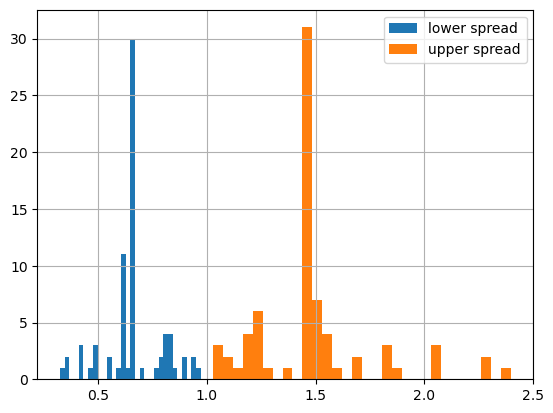

In [56]:
lower_spread = intervention_flow_defined_uncertainty_bounds_df['lower'] / intervention_flow_defined_uncertainty_bounds_df['mean']
upper_spread = intervention_flow_defined_uncertainty_bounds_df['upper'] / intervention_flow_defined_uncertainty_bounds_df['mean']
ax = lower_spread.hist(bins=30, label='lower spread')
upper_spread.hist(bins=30, label='upper spread', ax=ax)
ax.legend()
print('upper spread statistics')
print(upper_spread.describe())
print('\nlower spread statistics')
print(lower_spread.describe())

based on the statistics below, I decided to use the mean of the means fraction of the upper and lower bound

In [57]:
intervention_flow_upper_spread_scaling_factor = upper_spread.mean()
intervention_flow_lower_spread_scaling_factor = lower_spread.mean()
print('The upper spread scaling factor for intervention flows is: {}\nThe lower spread scaling factor for intervention flows is: {}'.format(intervention_flow_upper_spread_scaling_factor, intervention_flow_lower_spread_scaling_factor))

The upper spread scaling factor for intervention flows is: 1.4956226413685307
The lower spread scaling factor for intervention flows is: 0.6592225311025416


Based on this the bounds of the intervention flows without uncertainty is computed

In [65]:
intervention_flow_undefined_uncertainty_bounds = {}
for intervention_flow_index in intervention_flows_undefined_uncertainty:
    intervention_flow_uncertainty_dict = {
        'median': intervention_metadata_df.loc[intervention_flow_index].amount,
        'upper': intervention_flow_upper_spread_scaling_factor * intervention_metadata_df.loc[intervention_flow_index].amount,
        'lower': intervention_flow_lower_spread_scaling_factor * intervention_metadata_df.loc[intervention_flow_index].amount
    }
    intervention_flow_undefined_uncertainty_bounds[intervention_flow_index] = intervention_flow_uncertainty_dict

Test if the bounds are valid: upper-bound > lower-bound

In [69]:
intervention_flow_undefined_uncertainty_bounds_df = pd.DataFrame(intervention_flow_undefined_uncertainty_bounds).T
if ((intervention_flow_undefined_uncertainty_bounds_df['upper'] - intervention_flow_undefined_uncertainty_bounds_df['lower']) <= 0).any():
    raise Exception('There is one bound where the lower bound which is equal or larger than the upper bound')

#### 3.2.2. Set the uncertainty concept for the characterization factors and compute the bounds

The characterization factors uncertainty depend strongly on the method chosen and also on the time horizon etc.

**For now we are choosing an arbitrary bound scaling value of 0.3**

In [70]:
characterization_factor_upper_scaling_factor = 1.3
characterization_factor_lower_scaling_factor = 0.7

Compute the bounds based on the scaling factor

In [71]:
if len(characterization_factors_defined_uncertainty) > 0:
    raise Exception('There are characterization factor uncertainty in the data, use these! (code not implemented yet, but analogueous to intervention flows)')

characterization_factors_undefined_uncertainty_bounds = {}
for characterization_factor_index in characterization_factors_undefined_uncertainty:
    characterization_factor_uncertainty_dict = {
        'median': characterization_metadata_df.loc[characterization_factor_index].amount,
        'lower': characterization_factor_lower_scaling_factor * characterization_metadata_df.loc[characterization_factor_index].amount,
        'upper': characterization_factor_upper_scaling_factor * characterization_metadata_df.loc[characterization_factor_index].amount
    }
    characterization_factors_undefined_uncertainty_bounds[characterization_factor_index] = characterization_factor_uncertainty_dict

Test if the bounds are valid: upper-bound > lower-bound

In [72]:
characterization_factors_undefined_uncertainty_bounds_df = pd.DataFrame(characterization_factors_undefined_uncertainty_bounds).T
if ((characterization_factors_undefined_uncertainty_bounds_df['upper'] - characterization_factors_undefined_uncertainty_bounds_df['lower']) <= 0).any():
    raise Exception('There is one bound where the lower bound which is equal or larger than the upper bound')

## 4. Define the global sensitivity problem
### 4.1. Define the bound/interval of the parameters
Defining the bound as plus minus the standard deviation, $\sigma^2$, of the nominal value, $\mu$, for each parameter, $p$:

$[\mu_p - \sigma^2_p; \mu_p + \sigma^2_p]$

### 4.2. Defining the sampling problems

In [73]:
all_bounds = intervention_flow_defined_uncertainty_bounds | intervention_flow_undefined_uncertainty_bounds | characterization_factors_undefined_uncertainty_bounds
all_bounds_indx_dict = {
    "intervention_flows_end": len(intervention_flow_defined_uncertainty_bounds | intervention_flow_undefined_uncertainty_bounds),
    "characterization_factors_start":len(intervention_flow_defined_uncertainty_bounds | intervention_flow_undefined_uncertainty_bounds),
}

In [74]:
problem = {
    'num_vars': len(all_bounds),
    'names': list(all_bounds.keys()),
    'bounds': [[bound['lower'], bound['upper']]for bound in all_bounds.values()]
}

### 4.3. Define the sampling method

Select the sampling method, any sampling method from SALib can be chosen, but for most sensitivity analysis there is a sampling method best suited or even neccessary, in this case we use `saltelli` sampling because it is best compatible with Sobol' sequence.

In [75]:
from SALib.sample import sobol as sample_method

Choose the amount of samples 

In [76]:
N = 2**7
N

128

### 4.4. Define the sensitivity analysis method

Select the sensitivity analysis method, remember it is mostly coupled to the sampling method, any sensitivity method from the SALib can be chosen. For this case study we chose Sobol' method

In [77]:
from SALib.analyze import sobol as SA_method

## 5. Perform the sensitivity analysis

$$
    e(Q, B) =  Q \cdot B \cdot s
$$

### 5.1. Sampling the $Q$ and $B$ arrays

In [78]:
sample_data = sample_method.sample(problem, N)

### 5.2. Solving for $Q \cdot B \cdot s$

extract matrizes from sample data

In [79]:
sample_intervention_flows = pd.DataFrame(
    sample_data[:,:all_bounds_indx_dict['intervention_flows_end']], 
    columns=pd.MultiIndex.from_tuples(problem['names'][:all_bounds_indx_dict['intervention_flows_end']])
    )
sample_characterization_factors = pd.DataFrame(
    sample_data[:,all_bounds_indx_dict['characterization_factors_start']:], 
    columns=problem['names'][all_bounds_indx_dict['characterization_factors_start']:]
    )

Compute the environmental costs $Q \cdot B$ by reindexing the chracterization factors sample based on the intervention flow sample, so we can do dot product between for each characterization factors corresponding to the intervnetnion flow

In [80]:
sample_characterization_factors_expanded = sample_characterization_factors.reindex(sample_intervention_flows.columns, axis=1, level=0)
sample_environmental_costs = sample_characterization_factors_expanded * sample_intervention_flows

Compute the environmental impact using a dot product of the reindex scaling vector

In [81]:
scaling_vector_expanded = scaling_vector_series.reindex(sample_intervention_flows.columns, level=1)

In [82]:
sample_characterized_inventories = sample_environmental_costs * scaling_vector_expanded

### 5.3. Calculate the total output variance

Since we have multiple impact categories in the sampled data and we can only perform the sensitivity analysis per category, we have to specify the category from the data

In [83]:
sample_impacts = sample_characterized_inventories.sum(axis=1)

Test if the bounds are valid: upper-bound > lower-bound

In [ ]:
intervention_flow_undefined_uncertainty_bounds_df = pd.DataFrame(intervention_flow_undefined_uncertainty_bounds).T
if ((intervention_flow_undefined_uncertainty_bounds_df['upper'] - intervention_flow_undefined_uncertainty_bounds_df['lower']) <= 0).any():
    raise Exception('There is one bound where the lower bound which is equal or larger than the upper bound')

In [113]:
print(f'The statistics of the the sample impacts: {method}')
print(sample_impacts.describe())
print('The deterministic impact is {}'.format('\n'.join(['{} : {:e}'.format(values[0], values[1]) for values in result_data['impacts'].values])))

The statistics of the the sample impacts: ('ReCiPe Endpoint (E,A)', 'resources', 'total')
count    2.636800e+04
mean     7.296988e+08
std      9.860440e+07
min      4.711248e+08
25%      6.617561e+08
50%      7.183040e+08
75%      8.027651e+08
max      1.045868e+09
dtype: float64
The deterministic impact is ('ReCiPe Endpoint (E,A)', 'resources', 'total') : 6.763921e+08


#### 5.3.1.  Show the z-value and the distribution of the output

(26368,)

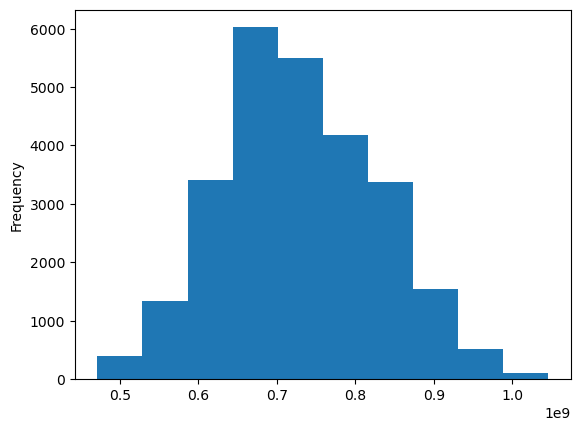

In [114]:
sample_impacts.plot.hist(bins=10)
sample_impacts.shape

The z-value of the total environmental impact

In [115]:
sample_impacts.std()/sample_impacts.mean()

0.13513027704749986

### 5.4. Calculate Sobol index

In [119]:
Si_impacts = SA_method.analyze(problem, sample_impacts.values)

/Users/hausslingbhl/miniconda3/envs/pulpo_dev/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [121]:
# total_Si_impacts, first_Si_impacts, second_Si_impacts = Si_impacts.to_df()
total_Si_impacts = pd.DataFrame([Si_imapcts['ST'].T, Si_imapcts['ST_conf'].T], index=['ST', 'ST_conf'], columns=problem['names']).T

#### 5.4.1. Calculate total explained variance

In [122]:
print("The total explained variance is \n{:.4}%".format(total_Si_impacts["ST"].sum()*100))

The total explained variance is 
102.7%


#### 5.5. Plot the contribution to variance

Generate the data and the names for the contribution plot

In [123]:
def set_size(width, height, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.
 
    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy
 
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction    
 
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27
 
    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2
 
    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    if height: #if height is specified
        fig_height_pt = height * fraction
        fig_height_in = fig_height_pt * inches_per_pt
    else:
        fig_height_in = fig_width_in * golden_ratio
 
    fig_dim = (fig_width_in, fig_height_in)
 
    return fig_dim

In [124]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import textwrap

def plot_SA_barplot(data:pd.DataFrame, metadata:pd.DataFrame, colormap:pd.Series=pd.Series([]), bbox_to_anchor_lower:float = -0.6, bbox_to_anchor_center:float=0.5):
    """
        Barplot of the contributional variance of the parameters in an objective

        args:
            data:       dataframe with columns: "ST" and "ST_conf"
            metadata:   metadataframe with "bar_names" column and same indices as data
            colormap:   Series with color codes to each data index     `colormap = pd.Series(mpl.cm.tab20.colors[:data.shape[0]], index=data.index)`
            bbox_to_anchor_lower: negative float, scaled how much the legend is under the plot
    """
    # width = 180
    # height = 180
    width = 4.77*72.4#600
    height = None
    _, ax = plt.subplots(1, 1, figsize=set_size(width,height))

    # Data
    data = data.sort_values(["ST"], ascending=False)
    heights = data["ST"].values * 100
    yerrs = data["ST_conf"].values * 100
    bars = [textwrap.fill(string, 50) for string in metadata["bar_names"].reindex(data.index)]
    y_pos = range(len(bars))
    
    for height, y_po, yerr, indx in zip(heights, y_pos, yerrs, data.index):
        ax.bar(y_po, height, yerr=yerr, capsize=5, ecolor="gray", color=colormap[indx], alpha=0.9)
    ax.set_xticks([])
    if (data["ST"]<=1).all() and (data["ST"]>=0).all():
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
        # For the minor ticks, use no labels; default NullFormatter.
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ax.legend(bars, loc='lower center', bbox_to_anchor=(bbox_to_anchor_center, bbox_to_anchor_lower), borderpad=1)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dotted')
    return ax

In [126]:
metadata_dict = {}
for (intervention_index, process_index) in total_Si_impacts.index[:all_bounds_indx_dict['intervention_flows_end']]:
    metadata_dict[(intervention_index, process_index)] = '{} --- {}'.format(pulpo_worker.lci_data['process_map_metadata'][process_index], pulpo_worker.lci_data['intervention_map_metadata'][intervention_index])
for intervention_index in total_Si_impacts.index[all_bounds_indx_dict['characterization_factors_start']:]:
    metadata_dict[intervention_index] = '{} --- {}'.format(pulpo_worker.lci_data['intervention_map_metadata'][intervention_index], method)
metadata_total_Si_impacts = pd.DataFrame([metadata_dict], index=['bar_names']).T

In [127]:
total_Si_impacts_top10 = total_Si_impacts.sort_values('ST', ascending=False).iloc[:10,:]
metadata_total_Si_impacts_top10 = metadata_total_Si_impacts.loc[total_Si_impacts_top10.index]

<Axes: >

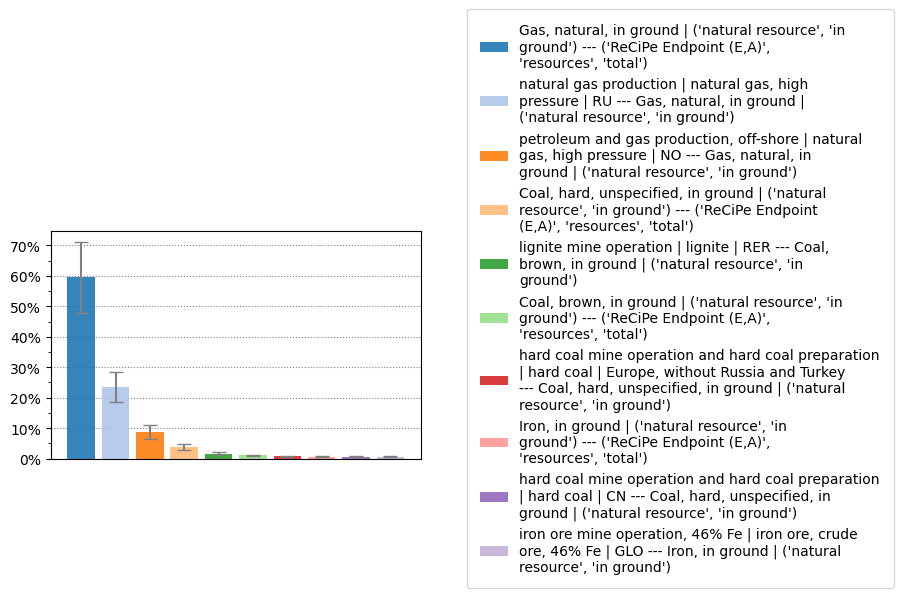

In [146]:
colormap_base = mpl.cm.tab20.colors
colormap_SA_barplot = pd.Series(colormap_base[:total_Si_impacts_top10.shape[0]], index=total_Si_impacts_top10.index)
plot_SA_barplot(data=total_Si_impacts_top10, metadata=metadata_total_Si_impacts_top10, colormap=colormap_SA_barplot, bbox_to_anchor_center=1.7, bbox_to_anchor_lower=-.6)

### 5.6. Plot the main contributing variables to the total environmental impact

In [129]:
e_QBs = sample_impacts
QBs_per_s_sample = sample_characterized_inventories

Generate the data

In [130]:
QBs_tops_indcs = QBs_per_s_sample.mean().abs().sort_values(ascending=False).iloc[:10].index
data_QBs = pd.DataFrame([])
QBs_per_s_sample_scaled = QBs_per_s_sample/ e_QBs.mean()#.divide(QBs_per_s_sample.abs().sum(axis=1), axis="index")
data_QBs["ST"] = QBs_per_s_sample_scaled.mean()[QBs_tops_indcs]
data_QBs["ST_conf"] = QBs_per_s_sample_scaled.std()[QBs_tops_indcs]
data_QBs.index = data_QBs.index.to_flat_index()
metadata_QBs = metadata_total_Si_impacts.loc[data_QBs.index]

#### 3.2.1. Set the uncertainty concept for the intervention flows and compute the bounds

Plot the total environmental impact for the top processes

In [152]:
from typing import Optional
# set matplotlib colormap

def plot_total_env_impact_barplot(data:pd.DataFrame,  metadata:pd.DataFrame, impact_category:str, colormap_base:tuple, colormap_linked:pd.Series=pd.Series([]), savefig:Optional[bool]=None, bbox_to_anchor_center:float=0.5):
    """
        Barplot of the contributional variance of the parameters in total cost objective

        args:
            data:       dataframe with columns: "ST" and "ST_conf"
            metadata:   metadataframe with "bar_names" column and same indices as data
            impact_category:    name of environmental impact category
            colormap_base:      The colormap which should be used for the plot, use the same as underlying the colormap_linked if it is specified
            colormap_linked:    If there is a colormap from another plot where the variables shown in this plot should refer to if they appear in both
            savefig:    if true saves fig into specified path
    """
    bbox_to_anchor_lower = .7
    bbox_to_anchor_center = .7
    if colormap_linked.empty:
        colormap = pd.Series(colormap_base[:data.shape[0]], index=data.index)
    else:
        # act_indcs = [index for index in colormap.index if type(index[1]) == int]
        # colormap_red = pd.Series(colormap[act_indcs].values, index=[indcs[1] for indcs in act_indcs])
        colormap_red = colormap_linked.loc[colormap_linked.index.isin(data.index)]
        addtional_incs = data.index[~data.index.isin(colormap_red.index)]
        additional_colormap = pd.Series(
            colormap_base[colormap_linked.shape[0]:colormap_linked.shape[0]+len(addtional_incs)], 
            index = addtional_incs
            )
        colormap = pd.concat([colormap_red, additional_colormap])


    ax = plot_SA_barplot(data, metadata, colormap=colormap, bbox_to_anchor_lower=bbox_to_anchor_lower, bbox_to_anchor_center=bbox_to_anchor_center)    
    ax.set_xlabel("Main environmental parameters")
    ax.set_ylabel("Contribution to total {} in [\%]".format(impact_category))

    # Save figure
    if savefig:
        plt.savefig(r"C:\Users\admin\OneDrive - Carbon Minds GmbH\Dokumente\13 Students\MA_Bartolomeus_Löwgren\02_code\03_optimization_framework\04_case_studies\02_plots\total_env_impact_barplot" + ".{}".format(fileformat), format=fileformat, bbox_inches='tight')


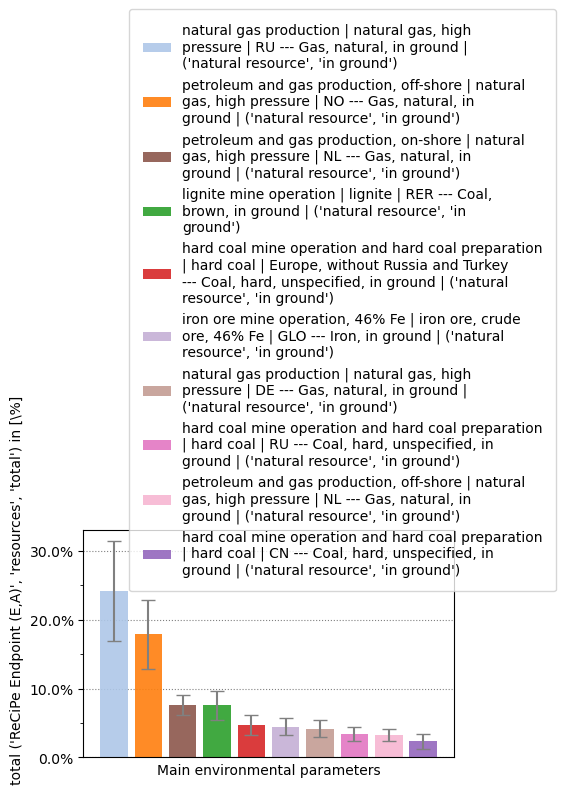

In [153]:
colormap = pd.Series(mpl.cm.tab20.colors[:data_QBs.shape[0]], index=data_QBs.index)
metadata_QBs = metadata_QBs[['bar_names']]
plot_total_env_impact_barplot(data_QBs, metadata=metadata_QBs, impact_category=method, colormap_base=colormap_base, colormap_linked=colormap_SA_barplot, savefig=False)